In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ramazanfratakda","key":"ed1566cc15f2c7491d66fcf38a8f266b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ciplab/real-and-fake-face-detection


Dataset URL: https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection
License(s): CC-BY-NC-SA-4.0
 99% 429M/431M [00:24<00:00, 21.6MB/s]
100% 431M/431M [00:24<00:00, 18.1MB/s]


In [ ]:
!unzip real-and-fake-face-detection.zip

Archive:  real-and-fake-face-detection.zip
  inflating: real_and_fake_face/training_fake/easy_100_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_101_0010.jpg  
  inflating: real_and_fake_face/training_fake/easy_102_0101.jpg  
  inflating: real_and_fake_face/training_fake/easy_103_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_104_1000.jpg  
  inflating: real_and_fake_face/training_fake/easy_105_1100.jpg  
  inflating: real_and_fake_face/training_fake/easy_106_0011.jpg  
  inflating: real_and_fake_face/training_fake/easy_107_1011.jpg  
  inflating: real_and_fake_face/training_fake/easy_108_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_109_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_10_0001.jpg  
  inflating: real_and_fake_face/training_fake/easy_110_0001.jpg  
  inflating: real_and_fake_face/training_fake/easy_111_1101.jpg  
  inflating: real_and_fake_face/training_fake/easy_112_1001.jpg  
  inflating: real_and_fake_face/tr

In [ ]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from glob import glob

from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [ ]:
def load_images_from_dir(path):
  images = []
  filenames = os.listdir(path)

  for file in filenames:
    img = cv2.imread(os.path.join(path,file))

    if img is not None:
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(image)

  return images

def preprocess_images(images, target_size=(224,224),):
    preprocessed_images = []

    for image in images :
      image = cv2.resize(image, target_size)
      image = image / 255 # normalizasyon
      preprocessed_images.append(image)

    return np.array(preprocessed_images)

In [ ]:
train_path = '/content/real_and_fake_face'


train_real_images = load_images_from_dir(train_path + '/training_real')
train_fake_images = load_images_from_dir(train_path + '/training_fake')


In [ ]:

# Gerçek ve sahte görüntüleri ayrı ayrı ön işleyin
processed_real_images = preprocess_images(train_real_images)
processed_fake_images = preprocess_images(train_fake_images)

# Görüntüleri birleştirerek tek bir eğitim seti oluşturun
x_train = np.concatenate([processed_real_images, processed_fake_images], axis=0)

# Etiketleri oluşturun: gerçek görüntüler için 1, sahte görüntüler için 0
y_train = np.array([1] * len(train_real_images) + [0] * len(train_fake_images))



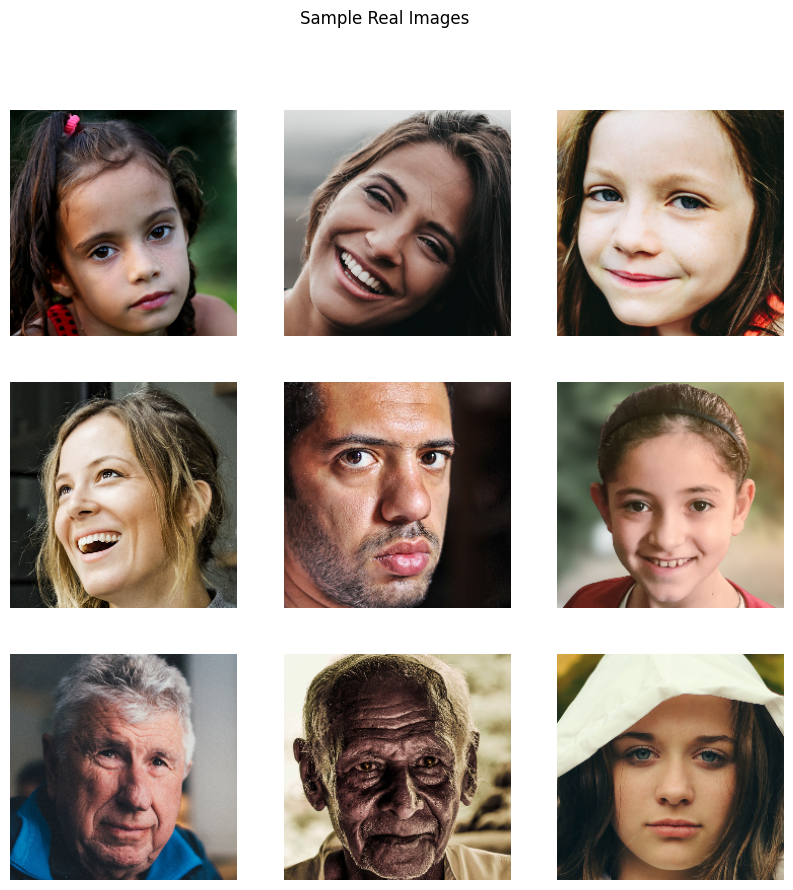

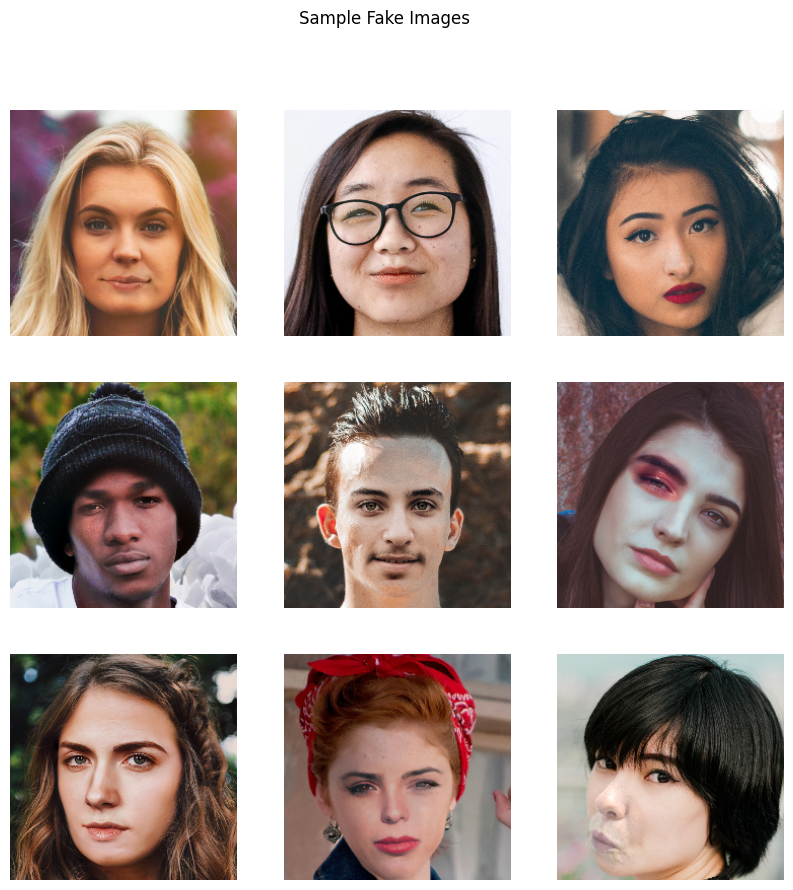

In [ ]:

import matplotlib.pyplot as plt

def show_image_grid(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(min(len(images), 9)):  # İlk 9 resmi göstermek için
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Real resimlerden örnekleri göster
show_image_grid(processed_real_images, 'Sample Real Images')

# Fake resimlerden örnekleri göster
show_image_grid(processed_fake_images, 'Sample Fake Images')


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

MobilenetV3Small


In [ ]:
mobilenet_small = keras.applications.MobileNetV3Small(
    input_shape=(224, 224,3 ),
   alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights="imagenet",
    dropout_rate=0.2,
    classifier_activation="sigmoid",
    classes=2,
    input_tensor=None,
    pooling=None,
    include_preprocessing=False,
)


mobilenet_small.summary()

In [ ]:
small_model = keras.Sequential()
small_model.add(mobilenet_small)
small_model.add(keras.layers.GlobalAveragePooling2D())
small_model.add(keras.layers.Dense(128, activation='relu'))
small_model.add(keras.layers.Dense(64, activation='relu'))
small_model.add(keras.layers.Dense(32, activation='relu'))
small_model.add(keras.layers.Dropout(0.5))
small_model.add(keras.layers.Dense(1, activation='sigmoid'))



small_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 576)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               73856     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0

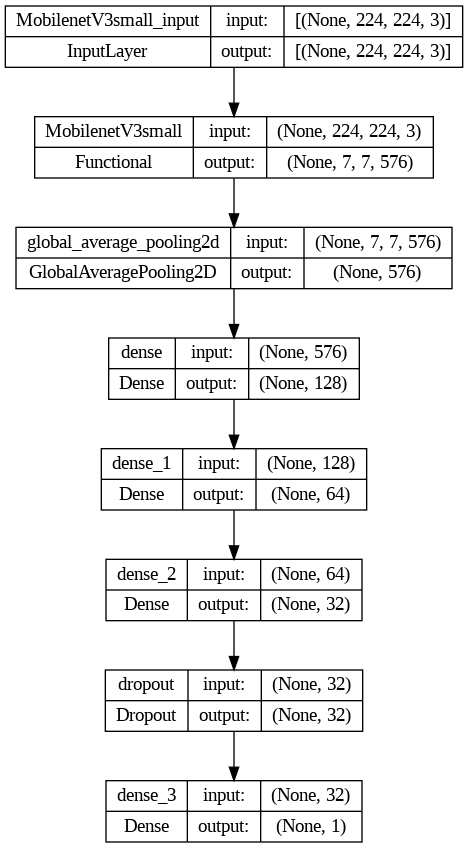

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(small_model, to_file='small_model.png', show_shapes=True, show_layer_names=True)

# Görselleştirmeyi notebook içinde görüntüleyin
Image(filename='small_model.png')

In [ ]:

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

small_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


small_history = small_model.fit(x_train, y_train, batch_size=32, epochs=50,shuffle=True, validation_data=(x_val, y_val))

test_loss, test_accuracy = small_model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Epoch 1/50
41/41 [==============================] - 37s 165ms/step - loss: 0.7263 - accuracy: 0.4912 - val_loss: 0.6929 - val_accuracy: 0.5168
Epoch 2/50
41/41 [==============================] - 2s 58ms/step - loss: 0.6648 - accuracy: 0.6084 - val_loss: 0.6965 - val_accuracy: 0.4862
Epoch 3/50
41/41 [==============================] - 2s 58ms/step - loss: 0.6235 - accuracy: 0.6483 - val_loss: 0.6972 - val_accuracy: 0.5107
Epoch 4/50
41/41 [==============================] - 2s 57ms/step - loss: 0.5848 - accuracy: 0.6874 - val_loss: 0.6960 - val_accuracy: 0.5352
Epoch 5/50
41/41 [==============================] - 2s 58ms/step - loss: 0.5006 - accuracy: 0.7686 - val_loss: 0.6933 - val_accuracy: 0.5841
Epoch 6/50
41/41 [==============================] - 2s 58ms/step - loss: 0.4257 - accuracy: 0.8153 - val_loss: 0.6866 - val_accuracy: 0.6116
Epoch 7/50
41/41 [==============================] - 2s 58ms/step - loss: 0.3593 - accuracy: 0.8529 - val_loss: 0.7326 - val_accuracy: 0.6055
Epoch 8/50


13/13 [==============================] - 0s 24ms/step - loss: 3.0079 - accuracy: 0.6015
Test Loss: 3.007874011993408
Test Accuracy: 0.6014670133590698
13/13 [==============================] - 1s 20ms/step


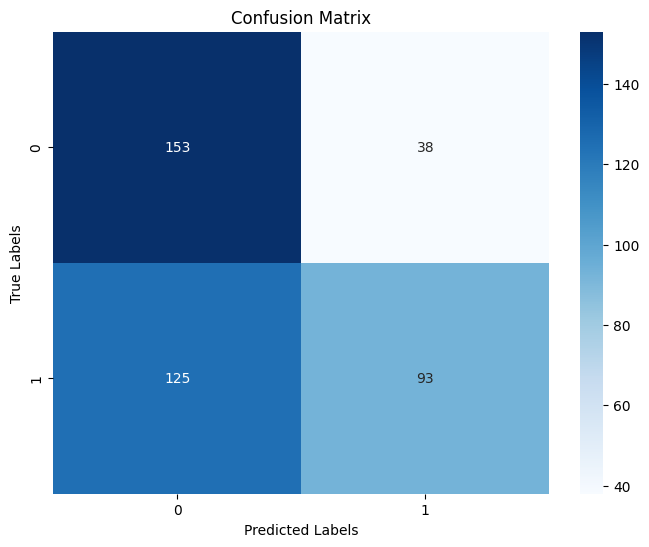

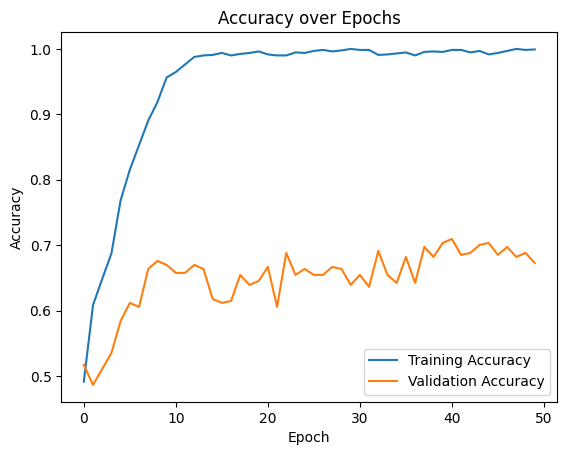

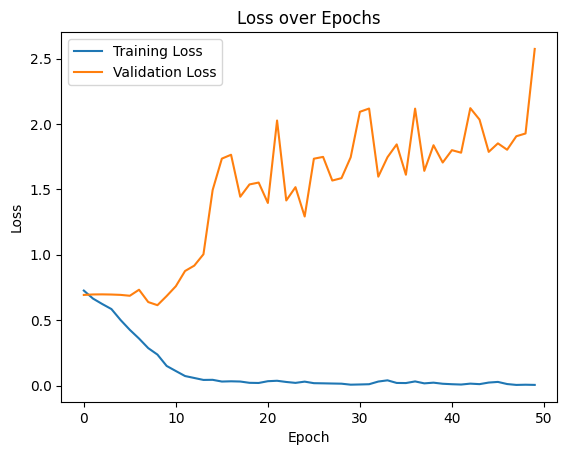

In [ ]:
test_loss, test_accuracy = small_model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminlerini al
y_pred = small_model.predict(x_test)
y_pred = (y_pred > 0.5)  # Sınıfları binary hale getir

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# large Modeli eğitirken history almamışız
# Accuracy grafiğini çizdir
plt.plot(small_history.history['accuracy'], label='Training Accuracy')
plt.plot(small_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Loss grafiğini çizdir
plt.plot(small_history.history['loss'], label='Training Loss')
plt.plot(small_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

MObilenetLarge


In [ ]:
mobilenet_large = keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    dropout_rate=0.2,
    pooling=None,
    classes=2,  # Sınıf sayısı
    classifier_activation='sigmoid'
)

mobilenet_large.trainable = False

mobilenet_large.summary()

12683000/12683000 [==============================] - 1s 0us/step
Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)        

In [ ]:
large_model = keras.Sequential()
large_model.add(mobilenet_large)
large_model.add(keras.layers.Flatten())
large_model.add(keras.layers.Dropout(0.1))
large_model.add(keras.layers.Dense(1, activation='sigmoid'))



large_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 47040)             0         
                                                                 
 dropout_1 (Dropout)         (None, 47040)             0         
                                                                 
 dense_4 (Dense)             (None, 1)                 47041     
                                                                 
Total params: 3043393 (11.61 MB)
Trainable params: 47041 (183.75 KB)
Non-trainable params: 2996352 (11.43 MB)
_________________________________________________________________


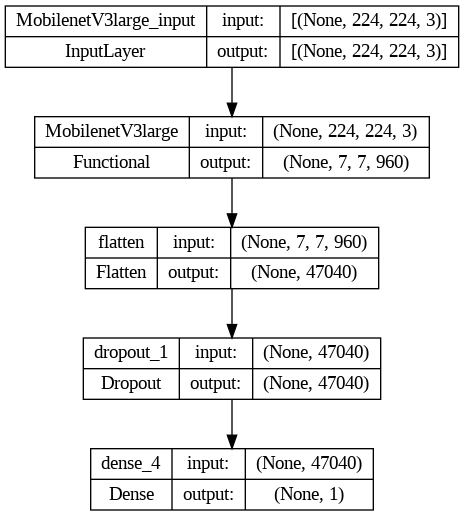

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(large_model, to_file='small_model.png', show_shapes=True, show_layer_names=True)

# Görselleştirmeyi notebook içinde görüntüleyin
Image(filename='small_model.png')

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

large_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


large_history = large_model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val))

test_loss, test_accuracy = large_model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Epoch 1/50
41/41 [==============================] - 10s 130ms/step - loss: 0.7104 - accuracy: 0.5211 - val_loss: 0.6990 - val_accuracy: 0.4954
Epoch 2/50
41/41 [==============================] - 2s 46ms/step - loss: 0.6905 - accuracy: 0.5471 - val_loss: 0.7022 - val_accuracy: 0.4985
Epoch 3/50
41/41 [==============================] - 2s 47ms/step - loss: 0.6907 - accuracy: 0.5479 - val_loss: 0.7163 - val_accuracy: 0.5168
Epoch 4/50
41/41 [==============================] - 2s 47ms/step - loss: 0.6852 - accuracy: 0.5517 - val_loss: 0.6963 - val_accuracy: 0.5321
Epoch 5/50
41/41 [==============================] - 2s 47ms/step - loss: 0.6811 - accuracy: 0.5594 - val_loss: 0.6902 - val_accuracy: 0.5382
Epoch 6/50
41/41 [==============================] - 2s 47ms/step - loss: 0.6717 - accuracy: 0.5885 - val_loss: 0.6920 - val_accuracy: 0.5046
Epoch 7/50
41/41 [==============================] - 2s 47ms/step - loss: 0.6708 - accuracy: 0.6023 - val_loss: 0.6891 - val_accuracy: 0.5352
Epoch 8/50


13/13 [==============================] - 1s 41ms/step - loss: 0.6794 - accuracy: 0.5746
Test Loss: 0.6794269680976868
Test Accuracy: 0.5745721459388733
13/13 [==============================] - 0s 33ms/step


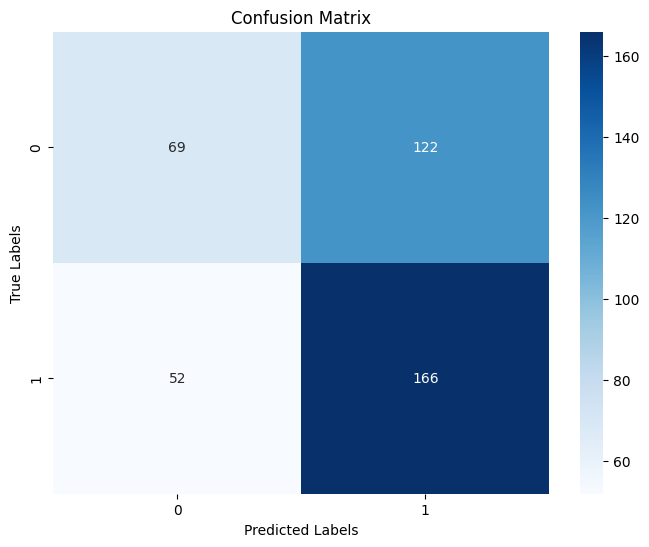

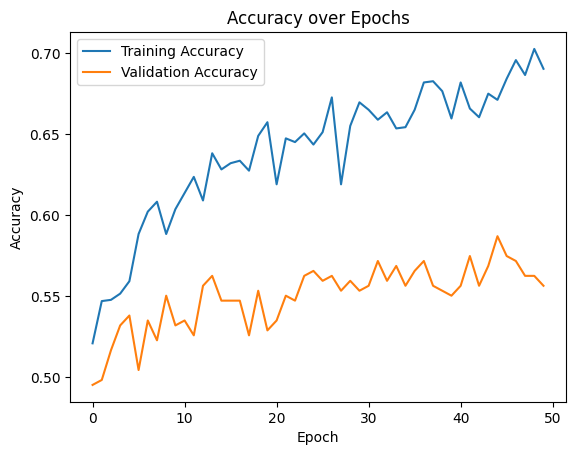

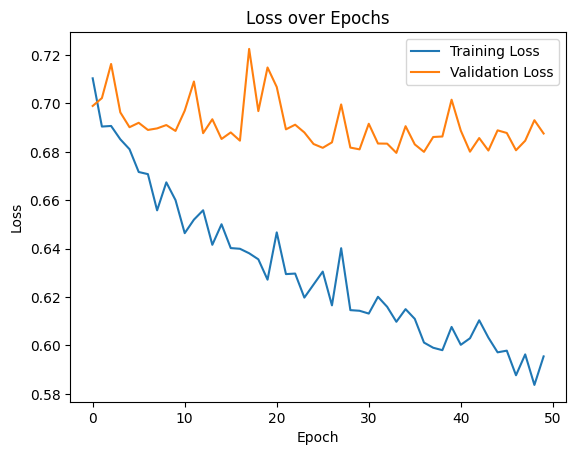

In [ ]:
test_loss, test_accuracy = large_model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminlerini al
y_pred = large_model.predict(x_test)
y_pred = (y_pred > 0.5)  # Sınıfları binary hale getir

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# large Modeli eğitirken history almamışız
# Accuracy grafiğini çizdir
plt.plot(large_history.history['accuracy'], label='Training Accuracy')
plt.plot(large_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Loss grafiğini çizdir
plt.plot(large_history.history['loss'], label='Training Loss')
plt.plot(large_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

Shufflenet

In [ ]:
!pip install keras_applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras import backend as K
#from keras.applications.imagenet_utils import _obtain_input_shape
from keras_applications.imagenet_utils import _obtain_input_shape
#from tensorflow.keras.models import Model


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout

from tensorflow.keras.layers import Activation, Add, Concatenate, GlobalAveragePooling2D,GlobalMaxPooling2D, Input, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Lambda

from tensorflow.keras.utils import get_file
from tensorflow.keras.layers import DepthwiseConv2D
import numpy as np
import numpy as np

from tensorflow.python.keras import backend as K

from tensorflow.python.util import nest
from tensorflow.python.util.tf_export import keras_export

def get_source_inputs(tensor, layer=None, node_index=None):

  if not hasattr(tensor, '_keras_history'):
    return tensor

  if layer is None or node_index:
    layer, node_index, _ = tensor._keras_history
  if not layer._inbound_nodes:
    return [tensor]
  else:
    node = layer._inbound_nodes[node_index]
    if not node.inbound_layers:
      # Reached an Input layer, stop recursion.
      return nest.flatten(node.input_tensors)
    else:
      source_tensors = []
      for layer, node_index, _, tensor in node.iterate_inbound():
        previous_sources = get_source_inputs(tensor, layer, node_index)
        # Avoid input redundancy.
        for x in previous_sources:
          if x not in source_tensors:
            source_tensors.append(x)
      return source_tensors

def ShuffleNet(include_top=True, input_tensor=None, scale_factor=1.0, pooling='max',weights = None,
               input_shape=(224,224,3), groups=1, load_model=None, num_shuffle_units=[3, 7, 3],
               bottleneck_ratio=0.25, classes=1000):

    if K.backend() != 'tensorflow':
        raise RuntimeError('Only TensorFlow backend is currently supported, '
                           'as other backends do not support ')

    name = "ShuffleNet_%.2gX_g%d_br_%.2g_%s" % (scale_factor, groups, bottleneck_ratio, "".join([str(x) for x in num_shuffle_units]))

    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)


    out_dim_stage_two = {1: 144, 2: 200, 3: 240, 4: 272, 8: 384}
    if groups not in out_dim_stage_two:
        raise ValueError("Invalid number of groups.")

    if pooling not in ['max','avg']:
        raise ValueError("Invalid value for pooling.")

    if not (float(scale_factor) * 4).is_integer():
        raise ValueError("Invalid value for scale_factor. Should be x over 4.")

    exp = np.insert(np.arange(0, len(num_shuffle_units), dtype=np.float32), 0, 0)
    out_channels_in_stage = 2 ** exp
    out_channels_in_stage *= out_dim_stage_two[groups]  # calculate output channels for each stage
    out_channels_in_stage[0] = 24  # first stage has always 24 output channels
    out_channels_in_stage *= scale_factor
    out_channels_in_stage = out_channels_in_stage.astype(int)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # create shufflenet architecture
    x = Conv2D(filters=out_channels_in_stage[0], kernel_size=(3, 3), padding='same',
               use_bias=False, strides=(2, 2), activation="relu", name="conv1")(img_input)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name="maxpool1")(x)

    # create stages containing shufflenet units beginning at stage 2
    for stage in range(0, len(num_shuffle_units)):
        repeat = num_shuffle_units[stage]
        x = _block(x, out_channels_in_stage, repeat=repeat,
                   bottleneck_ratio=bottleneck_ratio,
                   groups=groups, stage=stage + 2)

    if pooling == 'avg':
        x = GlobalAveragePooling2D(name="global_pool")(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name="global_pool")(x)

    if include_top:
        x = Dense(units=classes, name="fc")(x)
        x = Activation('softmax', name='softmax')(x)


    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs=inputs, outputs=x, name=name)

    if load_model is not None:
        model.load_weights('', by_name=True)

    return model


def _block(x, channel_map, bottleneck_ratio, repeat=1, groups=1, stage=1):

    x = _shuffle_unit(x, in_channels=channel_map[stage - 2],
                      out_channels=channel_map[stage - 1], strides=2,
                      groups=groups, bottleneck_ratio=bottleneck_ratio,
                      stage=stage, block=1)

    for i in range(1, repeat + 1):
        x = _shuffle_unit(x, in_channels=channel_map[stage - 1],
                          out_channels=channel_map[stage - 1], strides=1,
                          groups=groups, bottleneck_ratio=bottleneck_ratio,
                          stage=stage, block=(i + 1))

    return x


def _shuffle_unit(inputs, in_channels, out_channels, groups, bottleneck_ratio, strides=2, stage=1, block=1):

    if K.image_data_format() == 'channels_last':
        bn_axis = -1
    else:
        bn_axis = 1

    prefix = 'stage%d/block%d' % (stage, block)

    #if strides >= 2:
        #out_channels -= in_channels

    # default: 1/4 of the output channel of a ShuffleNet Unit
    bottleneck_channels = int(out_channels * bottleneck_ratio)
    groups = (1 if stage == 2 and block == 1 else groups)

    x = _group_conv(inputs, in_channels, out_channels=bottleneck_channels,
                    groups=(1 if stage == 2 and block == 1 else groups),
                    name='%s/1x1_gconv_1' % prefix)
    x = BatchNormalization(axis=bn_axis, name='%s/bn_gconv_1' % prefix)(x)
    x = Activation('relu', name='%s/relu_gconv_1' % prefix)(x)

    x = Lambda(channel_shuffle, arguments={'groups': groups}, name='%s/channel_shuffle' % prefix)(x)
    x = DepthwiseConv2D(kernel_size=(3, 3), padding="same", use_bias=False,
                        strides=strides, name='%s/1x1_dwconv_1' % prefix)(x)
    x = BatchNormalization(axis=bn_axis, name='%s/bn_dwconv_1' % prefix)(x)

    x = _group_conv(x, bottleneck_channels, out_channels=out_channels if strides == 1 else out_channels - in_channels,
                    groups=groups, name='%s/1x1_gconv_2' % prefix)
    x = BatchNormalization(axis=bn_axis, name='%s/bn_gconv_2' % prefix)(x)

    if strides < 2:
        ret = Add(name='%s/add' % prefix)([x, inputs])
    else:
        avg = AveragePooling2D(pool_size=3, strides=2, padding='same', name='%s/avg_pool' % prefix)(inputs)
        ret = Concatenate(bn_axis, name='%s/concat' % prefix)([x, avg])

    ret = Activation('relu', name='%s/relu_out' % prefix)(ret)

    return ret


def _group_conv(x, in_channels, out_channels, groups, kernel=1, stride=1, name=''):

    if groups == 1:
        return Conv2D(filters=out_channels, kernel_size=kernel, padding='same',
                      use_bias=False, strides=stride, name=name)(x)

    # number of intput channels per group
    ig = in_channels // groups
    group_list = []

    assert out_channels % groups == 0

    for i in range(groups):
        offset = i * ig
        group = Lambda(lambda z: z[:, :, :, offset: offset + ig], name='%s/g%d_slice' % (name, i))(x)
        group_list.append(Conv2D(int(0.5 + out_channels / groups), kernel_size=kernel, strides=stride,
                                 use_bias=False, padding='same', name='%s_/g%d' % (name, i))(group))
    return Concatenate(name='%s/concat' % name)(group_list)


def channel_shuffle(x, groups):

    height, width, in_channels = x.shape.as_list()[1:]
    channels_per_group = in_channels // groups

    x = K.reshape(x, [-1, height, width, groups, channels_per_group])
    x = K.permute_dimensions(x, (0, 1, 2, 4, 3))  # transpose
    x = K.reshape(x, [-1, height, width, in_channels])

    return x


In [ ]:
shufflenet_model = ShuffleNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


shufflenet_model.summary()

Model: "ShuffleNet_1X_g1_br_0.25_373"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 24)         648       ['input_3[0][0]']             
                                                                                                  
 maxpool1 (MaxPooling2D)     (None, 56, 56, 24)           0         ['conv1[0][0]']               
                                                                                                  
 stage2/block1/1x1_gconv_1   (None, 56, 56, 36)           864       ['maxpool1[0][0]']            
 (Conv2D)                                                              

In [ ]:
shuffle_model = keras.models.Sequential()
shuffle_model.add(shufflenet_model)  # Shufflenet modeli
shuffle_model.add(keras.layers.Flatten())  # Flatten katmanı
shuffle_model.add(keras.layers.Dense(256, activation='relu'))
shuffle_model.add(keras.layers.Dropout(0.3))
shuffle_model.add(keras.layers.Dense(1, activation='sigmoid'))  # Çıkış katmanı

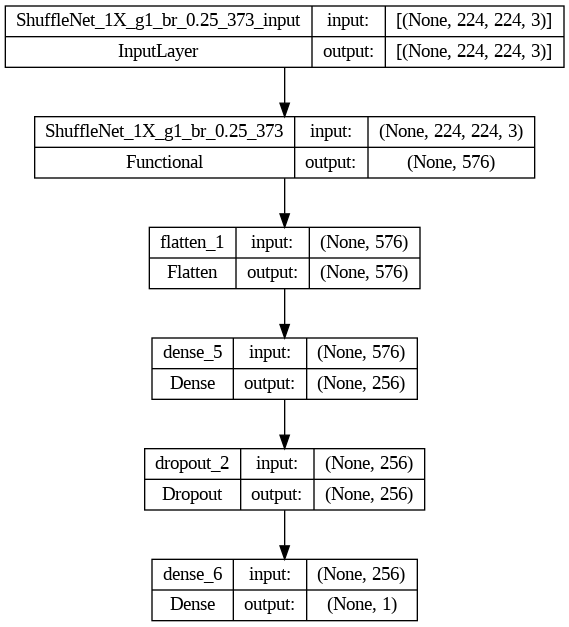

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(shuffle_model, to_file='small_model.png', show_shapes=True, show_layer_names=True)

# Görselleştirmeyi notebook içinde görüntüleyin
Image(filename='small_model.png')

In [ ]:

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
shuffle_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


shuffle_history = shuffle_model.fit(x_train, y_train, batch_size=32, epochs=50,shuffle=True, validation_data=(x_val, y_val))

test_loss, test_accuracy = shuffle_model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Epoch 1/50
41/41 [==============================] - 27s 126ms/step - loss: 2.3551 - accuracy: 0.4973 - val_loss: 0.6945 - val_accuracy: 0.4862
Epoch 2/50
41/41 [==============================] - 2s 53ms/step - loss: 1.6233 - accuracy: 0.5134 - val_loss: 0.6955 - val_accuracy: 0.4862
Epoch 3/50
41/41 [==============================] - 2s 55ms/step - loss: 1.1297 - accuracy: 0.5510 - val_loss: 0.6935 - val_accuracy: 0.4862
Epoch 4/50
41/41 [==============================] - 2s 54ms/step - loss: 0.8395 - accuracy: 0.6115 - val_loss: 0.6938 - val_accuracy: 0.4985
Epoch 5/50
41/41 [==============================] - 2s 54ms/step - loss: 0.6731 - accuracy: 0.6621 - val_loss: 0.6932 - val_accuracy: 0.5107
Epoch 6/50
41/41 [==============================] - 2s 54ms/step - loss: 0.6059 - accuracy: 0.6774 - val_loss: 0.6944 - val_accuracy: 0.4832
Epoch 7/50
41/41 [==============================] - 2s 54ms/step - loss: 0.5367 - accuracy: 0.7241 - val_loss: 0.6937 - val_accuracy: 0.5138
Epoch 8/50


13/13 [==============================] - 0s 23ms/step - loss: 1.7174 - accuracy: 0.5330
Test Loss: 1.7174433469772339
Test Accuracy: 0.5330073237419128
13/13 [==============================] - 1s 18ms/step


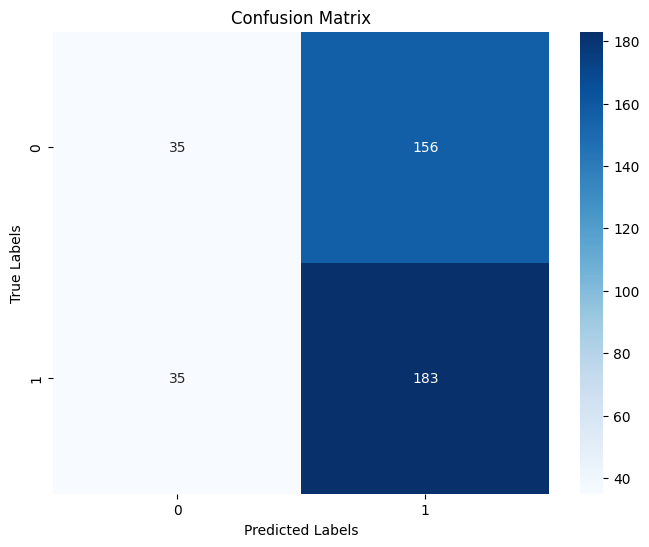

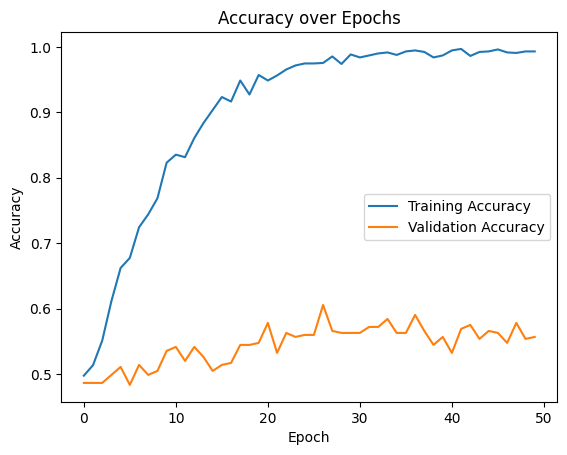

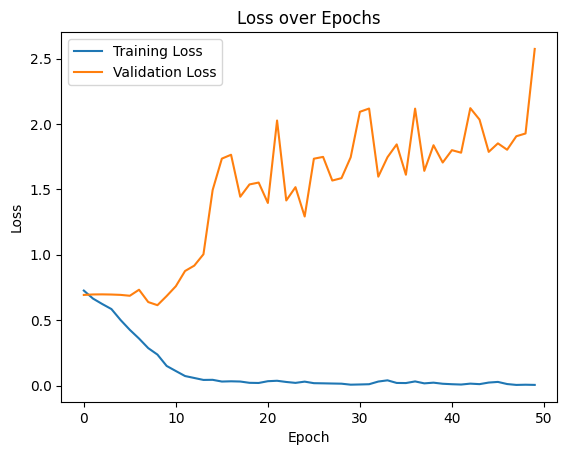

In [ ]:
test_loss, test_accuracy = shuffle_model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminlerini al
y_pred = shuffle_model.predict(x_test)
y_pred = (y_pred > 0.5)  # Sınıfları binary hale getir

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# large Modeli eğitirken history almamışız
# Accuracy grafiğini çizdir
plt.plot(shuffle_history.history['accuracy'], label='Training Accuracy')
plt.plot(shuffle_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Loss grafiğini çizdir
plt.plot(small_history.history['loss'], label='Training Loss')
plt.plot(small_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

SqueezeNet


In [ ]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
#from keras.engine.topology import get_source_inputs
from keras.utils import get_file
#from keras.utils import layer_utils

sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(input_tensor=None, input_shape=None,
               weights='imagenet',
               classes=1000,
              use_bn_on_input = False, # to avoid preprocessing
               first_stride = 2
              ):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                     require_flatten = False)

    if input_tensor is None:
        raw_img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if use_bn_on_input:
        img_input = BatchNormalization()(raw_img_input)
    else:
        img_input = raw_img_input


    x = Convolution2D(64, (3, 3), strides=(first_stride, first_stride), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    out = Activation('softmax', name='loss')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = raw_img_input

    model = Model(inputs, out, name='squeezenet')

    # load weights
    if weights == 'imagenet':

        weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [ ]:
squeeze_net_model = SqueezeNet(weights='imagenet',input_shape=(224, 224, 3), classes=1000)
squeeze_net_model.trainable = False

5059384/5059384 [==============================] - 0s 0us/step


In [ ]:
squeeze_model = keras.models.Sequential()
squeeze_model.add(squeeze_net_model)
squeeze_model.add(keras.layers.Flatten())  # Flatten katmanı
squeeze_model.add(keras.layers.Dropout(0.6))
squeeze_model.add(keras.layers.Dense(1, activation='sigmoid'))  # Çıkış katmanı

squeeze_model.layers[0].trainable = False

squeeze_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 squeezenet (Functional)     (None, 1000)              1235496   
                                                                 
 flatten_2 (Flatten)         (None, 1000)              0         
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense_7 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 1236497 (4.72 MB)
Trainable params: 1001 (3.91 KB)
Non-trainable params: 1235496 (4.71 MB)
_________________________________________________________________


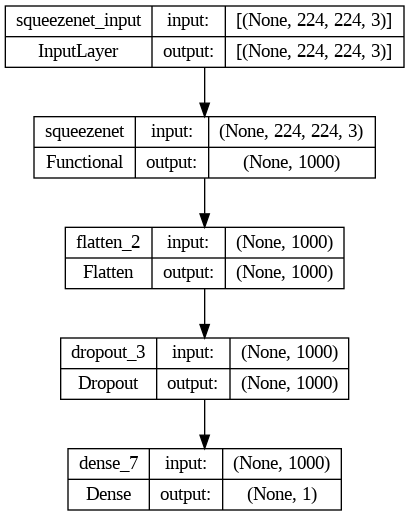

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(squeeze_model, to_file='small_model.png', show_shapes=True, show_layer_names=True)

# Görselleştirmeyi notebook içinde görüntüleyin
Image(filename='small_model.png')

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)

squeeze_model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])


squeeze_history = squeeze_model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val))

test_loss, test_accuracy = squeeze_model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Epoch 1/50
41/41 [==============================] - 6s 83ms/step - loss: 0.6928 - accuracy: 0.5211 - val_loss: 0.6930 - val_accuracy: 0.5138
Epoch 2/50
41/41 [==============================] - 1s 28ms/step - loss: 0.6929 - accuracy: 0.5180 - val_loss: 0.6930 - val_accuracy: 0.5138
Epoch 3/50
41/41 [==============================] - 1s 28ms/step - loss: 0.6929 - accuracy: 0.5218 - val_loss: 0.6929 - val_accuracy: 0.5138
Epoch 4/50
41/41 [==============================] - 1s 28ms/step - loss: 0.6927 - accuracy: 0.5280 - val_loss: 0.6929 - val_accuracy: 0.5138
Epoch 5/50
41/41 [==============================] - 1s 29ms/step - loss: 0.6922 - accuracy: 0.5364 - val_loss: 0.6929 - val_accuracy: 0.5138
Epoch 6/50
41/41 [==============================] - 1s 28ms/step - loss: 0.6926 - accuracy: 0.5310 - val_loss: 0.6929 - val_accuracy: 0.5138
Epoch 7/50
41/41 [==============================] - 1s 28ms/step - loss: 0.6927 - accuracy: 0.5341 - val_loss: 0.6929 - val_accuracy: 0.5138
Epoch 8/50
41

13/13 [==============================] - 0s 25ms/step - loss: 0.6911 - accuracy: 0.5330
Test Loss: 0.6911460161209106
Test Accuracy: 0.5330073237419128
13/13 [==============================] - 0s 19ms/step


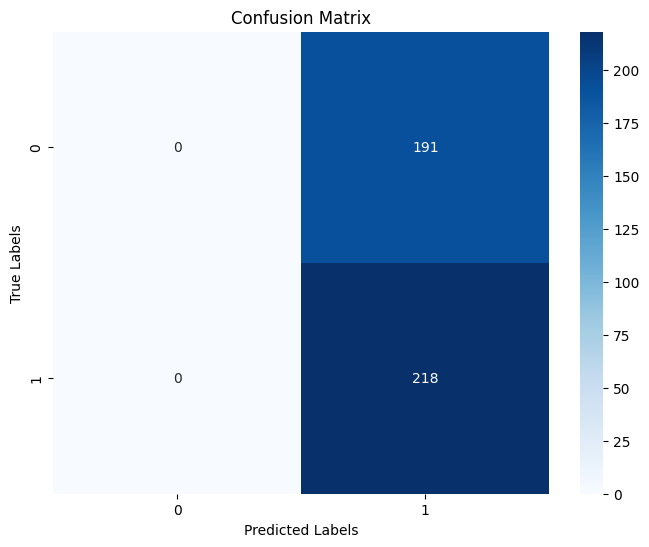

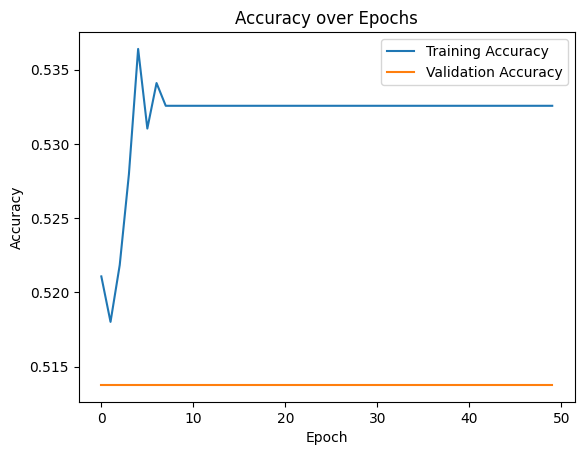

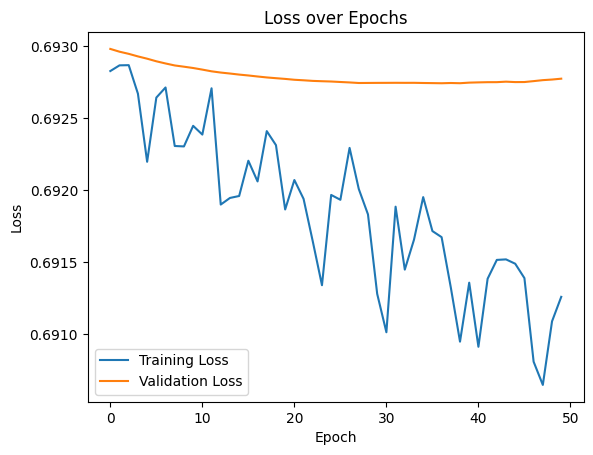

In [ ]:
test_loss, test_accuracy = squeeze_model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminlerini al
y_pred = squeeze_model.predict(x_test)
y_pred = (y_pred > 0.5)  # Sınıfları binary hale getir

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# large Modeli eğitirken history almamışız
# Accuracy grafiğini çizdir
plt.plot(squeeze_history.history['accuracy'], label='Training Accuracy')
plt.plot(squeeze_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Loss grafiğini çizdir
plt.plot(squeeze_history.history['loss'], label='Training Loss')
plt.plot(squeeze_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

Vgg

In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg.trainable = False

NameError: name 'keras' is not defined

In [ ]:
vgg_model = keras.models.Sequential()
vgg_model.add(vgg)
vgg_model.add(keras.layers.Flatten())
vgg_model.add(keras.layers.Dense(64, activation='relu'))
vgg_model.add(keras.layers.Dense(1, activation='sigmoid'))

vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                1605696   
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16320449 (62.26 MB)
Trainable params: 1605761 (6.13 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)


vgg_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

vgg_history = vgg_model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50, shuffle=True,
                    validation_data=(x_val, y_val))

test_loss, test_accuracy = vgg_model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Epoch 1/50
41/41 [==============================] - 21s 348ms/step - loss: 0.6765 - accuracy: 0.5862 - val_loss: 0.7096 - val_accuracy: 0.5780
Epoch 2/50
41/41 [==============================] - 6s 150ms/step - loss: 0.5777 - accuracy: 0.6966 - val_loss: 0.6482 - val_accuracy: 0.6361
Epoch 3/50
41/41 [==============================] - 6s 150ms/step - loss: 0.5022 - accuracy: 0.7678 - val_loss: 0.7067 - val_accuracy: 0.6208
Epoch 4/50
41/41 [==============================] - 6s 150ms/step - loss: 0.4602 - accuracy: 0.7946 - val_loss: 0.6575 - val_accuracy: 0.6667
Epoch 5/50
41/41 [==============================] - 6s 151ms/step - loss: 0.3978 - accuracy: 0.8544 - val_loss: 0.6691 - val_accuracy: 0.6544
Epoch 6/50
41/41 [==============================] - 6s 152ms/step - loss: 0.3646 - accuracy: 0.8766 - val_loss: 0.6866 - val_accuracy: 0.6024
Epoch 7/50
41/41 [==============================] - 6s 153ms/step - loss: 0.3267 - accuracy: 0.9050 - val_loss: 0.6936 - val_accuracy: 0.6453
Epoch

13/13 [==============================] - 2s 123ms/step - loss: 1.0983 - accuracy: 0.6430
Test Loss: 1.0983035564422607
Test Accuracy: 0.6430317759513855
13/13 [==============================] - 2s 123ms/step


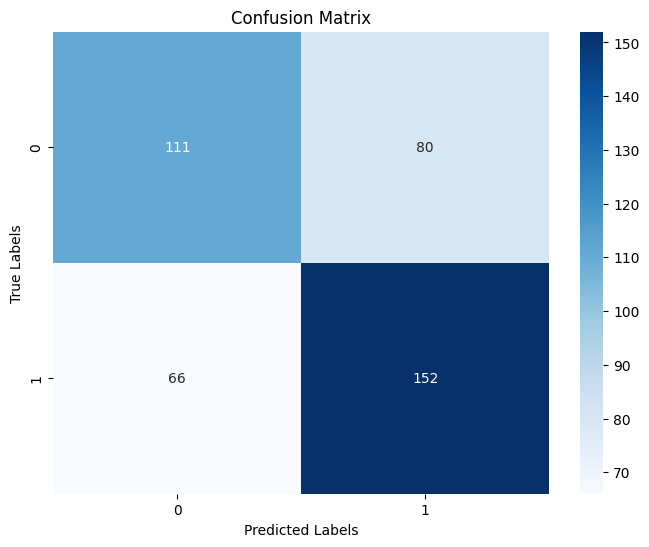

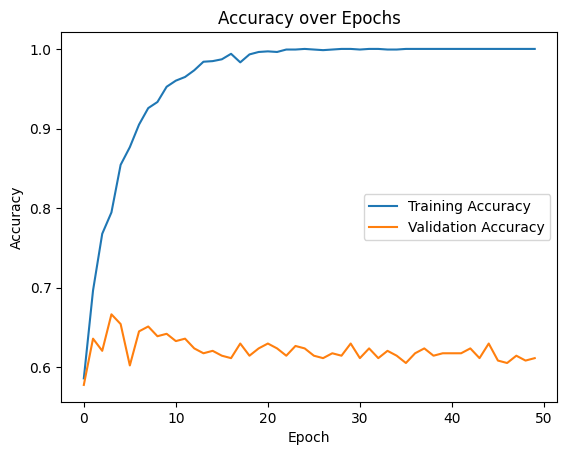

In [ ]:
test_loss, test_accuracy = vgg_model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminlerini al
y_pred = vgg_model.predict(x_test)
y_pred = (y_pred > 0.5)  # Sınıfları binary hale getir

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# large Modeli eğitirken history almamışız
# Accuracy grafiğini çizdir
plt.plot(vgg_history.history['accuracy'], label='Training Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()


Birleştirme (small & vgg)

In [ ]:
from keras.layers import Concatenate
output = Concatenate()([keras.layers.Flatten()(vgg_model.output), keras.layers.Flatten()(small_model.output)])

output = keras.layers.Dropout(0.8)(output)
output = keras.layers.Dense(1, activation='sigmoid')(output)

concat_model = Model(inputs = [vgg_model.input, small_model.input], outputs = output)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
concat_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
concat_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 MobilenetV3small_input (In  [(None, 224, 224, 3)]        0         []                            
 putLayer)                                                                                        
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['MobilenetV3small_input[0][0]
 al)                                                                ']                            
                                                                                                  
 global_average_pooling2d (  (None, 576)                  0         ['MobilenetV3small[0][0]']    
 GlobalAveragePooling2D)                                                                    

In [ ]:
concat_history = concat_model.fit([x_train, x_train], y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=([x_val, x_val], y_val))

test_loss,test_accuracy = concat_model.evaluate([x_test, x_test], y_test, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Epoch 1/50
41/41 [==============================] - 30s 257ms/step - loss: 0.8610 - accuracy: 0.4897 - val_loss: 0.7093 - val_accuracy: 0.5199
Epoch 2/50
41/41 [==============================] - 8s 205ms/step - loss: 0.7025 - accuracy: 0.4759 - val_loss: 0.6848 - val_accuracy: 0.5138
Epoch 3/50
41/41 [==============================] - 9s 208ms/step - loss: 0.6269 - accuracy: 0.4943 - val_loss: 0.6920 - val_accuracy: 0.5199
Epoch 4/50
41/41 [==============================] - 9s 209ms/step - loss: 0.6213 - accuracy: 0.4866 - val_loss: 0.6906 - val_accuracy: 0.5199
Epoch 5/50
41/41 [==============================] - 9s 212ms/step - loss: 0.6167 - accuracy: 0.5249 - val_loss: 0.6903 - val_accuracy: 0.5505
Epoch 6/50
41/41 [==============================] - 9s 216ms/step - loss: 0.6263 - accuracy: 0.4858 - val_loss: 0.6779 - val_accuracy: 0.5657
Epoch 7/50
41/41 [==============================] - 9s 219ms/step - loss: 0.6229 - accuracy: 0.5103 - val_loss: 0.6778 - val_accuracy: 0.5719
Epoch

In [ ]:
test_loss, test_accuracy = concat_model.evaluate([x_test,x_test], y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminlerini al
y_pred = concat_model.predict([x_test,x_test])
y_pred = (y_pred > 0.5)  # Sınıfları binary hale getir

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# large Modeli eğitirken history almamışız
# Accuracy grafiğini çizdir
plt.plot(concat_history.history['accuracy'], label='Training Accuracy')
plt.plot(concat_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()